In [2]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import WebDriverException
from bs4 import BeautifulSoup
import time
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
import numpy as np
import datetime
from selenium.webdriver.common.action_chains import ActionChains
import xlsxwriter
from openpyxl import Workbook, load_workbook
import os
import shutil
import logging
import traceback
import re
import csv
from azure.storage.blob import BlobServiceClient
import matplotlib.pyplot as plt
import seaborn as sns

# 

In [3]:
# File paths


# date_today = datetime.date.today().strftime("%Y-%m-%d")
# output_gyg = r'output/GYG'
# archive_folder = fr'{output_gyg}/Archive'
# file_path_done =fr'output/GYG/{date_today}-DONE-GYG.csv'  
# file_path_output = fr"output/GYG - {date_today}.xlsx"
# link_file = fr'resource/GYG_links.csv'
# avg_file = fr'resource/avg-gyg.csv'
# re_run_path = fr'output/GYG/{date_today}-ReRun-GYG.csv'
# folder_path_with_txt_to_count_avg = 'Avg/GYG'

date_today = datetime.date.today().strftime("%Y-%m-%d")
date_today = '2024-03-32'
output_gyg = r'G:/.shortcut-targets-by-id/1ER8hilqZ2TuX2C34R3SMAtd1Xbk94LE2/MyOTAs/Baza Excel/Get Your Guide'
archive_folder = fr'{output_gyg}/Archive'
file_path_done =fr'{output_gyg}/{date_today}-DONE-GYG.csv'  
file_path_output = fr"{output_gyg}/GYG - {date_today}.xlsx"
link_file = fr'G:/.shortcut-targets-by-id/1ER8hilqZ2TuX2C34R3SMAtd1Xbk94LE2/MyOTAs/Baza Excel/Resource/GYG_links.csv'
max_page_file = fr'G:/.shortcut-targets-by-id/1ER8hilqZ2TuX2C34R3SMAtd1Xbk94LE2/MyOTAs/Baza Excel/Resource/GYG_max_page.csv'
avg_file = fr'G:/.shortcut-targets-by-id/1ER8hilqZ2TuX2C34R3SMAtd1Xbk94LE2/MyOTAs/Baza Excel/Resource/avg-gyg.csv'
re_run_path = fr'{output_gyg}/{date_today}-ReRun-GYG.csv'
logs_path = fr'G:/.shortcut-targets-by-id/1ER8hilqZ2TuX2C34R3SMAtd1Xbk94LE2/MyOTAs/Baza Excel/Logs/GYG'
# FOR ONE TIME USED NOT SYNCHORNIEZD WITH RUNING APPLCIATION
folder_path_with_txt_to_count_avg = 'Avg/GYG'

# Set the path of the local file
local_file_path = f"{output_gyg}/GYG - {date_today}.xlsx"

# Set the name of your Azure Storage account and the corresponding access key
storage_account_name = "storagemyotas"
storage_account_key = "vyHHUXSN761ELqivtl/U3F61lUY27jGrLIKOyAplmE0krUzwaJuFVomDXsIc51ZkFWMjtxZ8wJiN+AStbsJHjA=="

# Set the name of the container anad the desired blob name
container_name_raw = "raw/daily/gyg"
container_name_refined = "refined/daily/gyg"

blob_name = fr'GYG - {date_today}.xlsx'
file_path_logs_processed = fr'G:/.shortcut-targets-by-id/1ER8hilqZ2TuX2C34R3SMAtd1Xbk94LE2/MyOTAs/Baza Excel/Logs/files_processed/{blob_name.split(".")[0]}'


In [4]:


# Load the data

file_path = f'{output_gyg}/2024-03-32-Venice-GYG.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()


,Tytul,Tytul URL,Cena,Opinia,IloscOpini,Przecena,Tekst,Data zestawienia,Pozycja,Kategoria,Booked,SiteUse,Miasto,VPN_City
0,Venice: Marco Polo Airport Water Taxi Transfer,https://www.getyourguide.com/venice-l35/venice...,€ 37,4.4,15894.0,NaN,TransferVenice: Marco Polo Airport Water Taxi ...,27/03/2024,1,Global,Booked 55 times yesterday,GYG,Venice,Krakow
1,Venice: Doge's Palace Reserved Entry Ticket,https://www.getyourguide.com/venice-l35/venice...,€ 30,4.6,25478.0,NaN,Entry ticketVenice: Doge's Palace Reserved Ent...,27/03/2024,2,Global,Booked 211 times yesterday,GYG,Venice,Krakow
2,Morning - Explore Venice: Gondola & On Foot,https://www.getyourguide.com/venice-l35/mornin...,€ 122.40,NaN,NaN,NaN,Guided tourMorning - Explore Venice: Gondola &...,27/03/2024,3,Global,New activity,GYG,Venice,Krakow
3,Doge's Palace & St. Mark's Basilica with Terra...,https://www.getyourguide.com/venice-l35/st-mar...,€ 99,4.7,7832.0,NaN,Top ratedGuided tourDoge's Palace & St. Mark's...,27/03/2024,4,Global,Booked 39 times yesterday,GYG,Venice,Krakow
4,Venice: Bus Transfer between Marco Polo Airpor...,https://www.getyourguide.com/venice-l35/venice...,€ 10,4.7,18264.0,NaN,Top ratedTransferVenice: Bus Transfer between ...,27/03/2024,5,Global,Booked 75 times yesterday,GYG,Venice,Krakow


In [5]:
# Identifying the specific URLs that are not present in all VPN cities and the cities they are missing in
url_presence = pd.crosstab(data['Tytul URL'], data['VPN_City'])
missing_urls_cities = (url_presence == 0).apply(lambda x: x.index[x].tolist(), axis=1)
missing_urls_cities = missing_urls_cities[missing_urls_cities.apply(len) > 0]

# Extracting the relevant details for these URLs
urls_missing_details = data[['Tytul URL', 'Tytul']].drop_duplicates().set_index('Tytul URL').loc[missing_urls_cities.index]
urls_missing_details['Missing in VPN_Cities'] = missing_urls_cities

urls_missing_details.reset_index(inplace=True)


In [6]:
# Aggregating data to create the requested matrix
# Calculating CountOfOccurance_inCity, Min Position, Max Position for each URL in its available cities
url_aggregated_info = data.groupby(['Tytul URL', 'Tytul', 'VPN_City']).agg({
    'Pozycja': ['count', 'min', 'max']
}).reset_index()

# Renaming columns for clarity
url_aggregated_info.columns = ['Tytul URL', 'Tytul', 'VPN_City', 'CountOfOccurance_inCity', 'Min Position', 'Max Position']

# Merging this aggregated info with the details of missing cities
url_matrix = pd.merge(url_aggregated_info, urls_missing_details[['Tytul URL', 'Missing in VPN_Cities']], on="Tytul URL", how="left")

# Ensuring all cities are represented, including where the URL is missing
url_matrix['VPN_City'] = url_matrix['VPN_City'].fillna('Missing')

# Aggregating to summarize over each URL, compiling lists for [Position], [Vpn City], and [VpnCity_missing]
url_summary_matrix = url_matrix.groupby('Tytul URL').agg({
    'Tytul': 'first',
    'VPN_City': list,
    'CountOfOccurance_inCity': 'sum',
    'Min Position': 'min',
    'Max Position': 'max',
    'Missing in VPN_Cities': 'first'
}).reset_index()

# Sorting the URL summary matrix by 'Min Position'
url_summary_matrix_sorted = url_summary_matrix.sort_values(by='Min Position')

url_summary_matrix_sorted


,Tytul URL,Tytul,VPN_City,CountOfOccurance_inCity,Min Position,Max Position,Missing in VPN_Cities
29,https://www.getyourguide.com/venice-l35/venice...,Venice: Marco Polo Airport Water Taxi Transfer,"[Frankfurt, Krakow, London, Milano, NewYork, P...",8,1,1,None
24,https://www.getyourguide.com/venice-l35/venice...,Venice: Doge's Palace Reserved Entry Ticket,"[Frankfurt, Krakow, London, Milano, NewYork, P...",8,2,2,None
18,https://www.getyourguide.com/venice-l35/veneti...,Venetian Magic: Walking and Gondola Adventure,"[London, Paris]",2,3,3,"[Frankfurt, Krakow, Milano, NewYork, Stockholm..."
4,https://www.getyourguide.com/venice-l35/ghosts...,Ghosts of Venice: Unveiling the Haunted Past,[NewYork],1,3,3,"[Frankfurt, Krakow, London, Milano, Paris, Sto..."
6,https://www.getyourguide.com/venice-l35/gondol...,Gondola & Wander: Discover Charming Venice,[Frankfurt],1,3,3,"[Krakow, London, Milano, NewYork, Paris, Stock..."
8,https://www.getyourguide.com/venice-l35/mornin...,Morning - Explore Venice: Gondola & On Foot,"[Krakow, London, Milano, Stockholme]",4,3,11,"[Frankfurt, NewYork, Paris, Vienna]"
11,https://www.getyourguide.com/venice-l35/photo-...,Photo shoot with a professional photographer i...,[Vienna],1,3,3,"[Frankfurt, Krakow, London, Milano, NewYork, P..."
17,https://www.getyourguide.com/venice-l35/st-mar...,Doge's Palace & St. Mark's Basilica with Terra...,"[Frankfurt, Krakow, London, Milano, NewYork, P...",8,4,4,None
23,https://www.getyourguide.com/venice-l35/venice...,Venice: Bus Transfer between Marco Polo Airpor...,"[Frankfurt, Krakow, London, Milano, NewYork, P...",8,5,5,None
14,https://www.getyourguide.com/venice-l35/romant...,Venice: Grand Canal by Gondola with Live Comme...,"[Frankfurt, Krakow, London, Milano, NewYork, P...",8,6,6,None


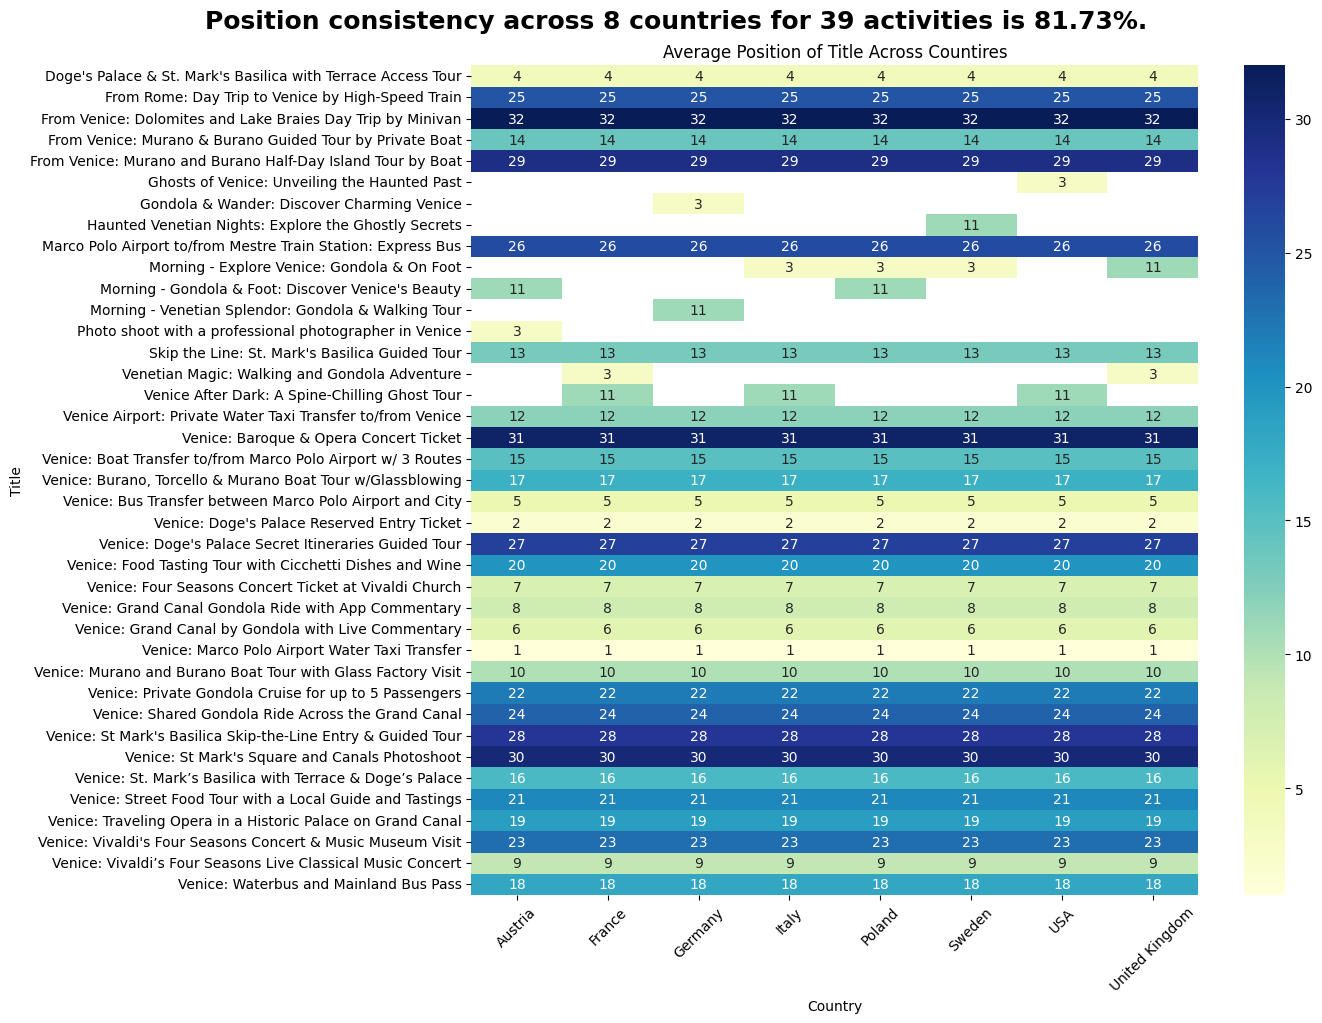

In [7]:
# Preparing data for a heatmap visualization: simplifying for a subset due to complexity
# For demonstration, we'll create a pivot table of URLs (rows) vs. VPN Cities (columns) with average positions as values
city_to_country = {
    'Frankfurt': 'Germany',
    'Krakow': 'Poland',
    'London': 'United Kingdom',
    'Milano': 'Italy',
    'NewYork': 'USA',
    'Paris': 'France',
    'Stockholme': 'Sweden',
    'Vienna': 'Austria',
    'Amsterdam': 'Netherlands'
}



# Creating a simplified subset for visualization purposes
heatmap_data_subset = data[['Tytul', 'VPN_City', 'Pozycja']].groupby(['Tytul', 'VPN_City']).mean().reset_index().sort_values(by='Pozycja')
heatmap_data_subset['Country'] = heatmap_data_subset['VPN_City'].map(city_to_country)
# Correcting the pivot call with keyword arguments
pivot_table = heatmap_data_subset.pivot(index='Tytul', columns='VPN_City', values='Pozycja')

country_based_aggregation = heatmap_data_subset.groupby(['Tytul', 'Country'])['Pozycja'].mean().reset_index()
pivot_table_country = country_based_aggregation.pivot(index='Tytul', columns='Country', values='Pozycja')

# Calculate the total differences
total_differences = pivot_table_country.apply(lambda x: pd.Series(x).nunique(), axis=1).sum()
differences = pivot_table_country.sub(pivot_table_country.median(axis=1), axis=0).abs()
total_differences = np.count_nonzero(differences)

# Total possible non-missing data points
total_possible_points = pivot_table_country.shape[0] * pivot_table_country.shape[1]

# Percentage of total differences
percentage_difference = (1-(total_differences / total_possible_points)) * 100



# Continuing with the heatmap visualization
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table_country, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title('Average Position of Title Across Countires')
plt.xlabel('Country')
plt.ylabel('Title')
plt.xticks(rotation=45)
plt.tight_layout()

num_countries = pivot_table_country.shape[1]  # Number of countries
num_activities = pivot_table_country.shape[0]  # Number of activities

# This is the text we will use for the annotation
data_quality_text = (f"Position consistency across {num_countries} countries for "
                     f"{num_activities} activities is {percentage_difference:.2f}%.")

# When adding the annotation to the plot, you would use this text variable
plt.gcf().text(0.15, 1, data_quality_text, fontsize=18, weight='bold')
plt.show()


In [15]:
# collect dataset

EUR_City = [
        "Amsterdam", "Athens", "Barcelona", "Berlin", "Dublin", "Dubrovnik", "Florence", "Istanbul",
        "Krakow", "Lisbon", "Madrid", "Milan", "Naples", "Paris", "Porto", "Rome", "Palermo", "Venice",
        "Taormina", "Capri", "Sorrento", "Mount-Etna", "Mount-Vesuvius", "Herculaneum", "Amalfi-Coast",
        "Pompeii"
    ]
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.maximize_window()
# Define the URL of the website we want to scrape
start_time = time.time()
total_pages = 0
iter = 0
df_links = pd.read_csv(link_file)


df_links = df_links[df_links['City'] == 'Venice']
df_links = df_links[df_links['Category'] == 'Global']


for index, row in df_links.iterrows():
        
    #     CHECK IF FILE PATH EXISIT IF SO CHECK THE DATA INSIDE
#         print(index, row)
        page = 1
        #######################################################################################
        #######################################################################################
        VPN_City = 'Krakow'
        max_pages = 8
        #######################################################################################
        #######################################################################################

        data = []
        position = 0
        url_time = time.time()
        while page <= max_pages:
            iter +=1
            url = f'{row["URL"]}&p={page}'
            print(url)
            if max_pages == 9999:
                max_pages = 'Set'
        
            driver.get(url)
            time.sleep(1)

            try:
                title_webpage = driver.title
                current_url = driver.current_url
                print(f'Title: {title_webpage} \n\n CURRENT URL: {current_url}')
            except WebDriverException:
                # If an exception occurs, it might indicate that the page is unresponsive
                print("The page might be unresponsive (possibly 'Aw, Snap!'). Attempting to refresh...")
                try:
                    driver.refresh()
                    time.sleep(1)  # Wait for the page to load after refresh
                except WebDriverException:
                    driver.quit()
                    print("Failed to refresh the page. Consider checking your setup or the website status.")
                    driver.get(url=url)
                    print('Closed and opens once again the webpage')
                    time.sleep(4)

            
        #     VERIFY IF THE CURRENCY IS CORRECT
            login_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//a[@title='Profile']")))
#             Below is previous version when the it was Log in instead Prfile
#             login_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//a[@title='Log in']")))
            login_button.click()
#             currency = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//a[@title='Select Currency']")))
            currency = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//a[@class='option option-currency']")))
            currency = currency.text.strip()
            if row['City'] in EUR_City:
                if 'EUR' in currency:
                    pass
                else:
                    login_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//a[@title='Profile']")))
                    login_button.click()
#                     currency_switcher_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//a[@title='Select Currency']")))
                    currency_switcher_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//a[@class='option option-currency']")))
                    # hover over the currency switcher button to show the menu
                    actions = ActionChains(driver)
                    actions.move_to_element(currency_switcher_button).perform()
                    currency_switcher_button .click()
                    # wait for the EUR currency option to be clickable
                    eur_currency_option = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//li[@class='currency-modal-picker__item-parent item__currency-modal item__currency-modal--EUR']")))
                    # click on the EUR currency option to change the currency
                    eur_currency_option.click()
                    time.sleep(2)
            # Parse the HTML content of the page using Beautiful Soup
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            if max_pages == 'Set':
                try:
                    max_pages = int((soup.find('span', {'class': 'trip-item-pagination__controls-info'}).text.strip()).split(' ')[-1])        
                except:
                    try:
                        max_pages = round(float(soup.find('div', {'class': 'search-header__left__data-wrapper__count'}).text.strip().split()[0])/40,0)+1
                        print('Divided by amount of activiytes: ', max_pages)
                    except:
                        max_pages = 5
                        print('Dindt found max page - new UI')
                total_pages = total_pages+max_pages
# #############################################                
#                 max_pages = 1
# #############################################

            # Extract the data from the HTML using Beautiful Soup
            tour_items = soup.find_all('li', {'class': 'list-element'})
            if len(tour_items) == 0:
                tour_items = soup.select("[data-test-id=vertical-activity-card]")
            # print(tour_items)
            date_today = datetime.datetime.now().strftime('%Y-%m-%d')
            for tour_item in tour_items:
                title = tour_item.find('h3', {'class': 'vertical-activity-card__title'}).text.strip()
                price = tour_item.find('div', {'class': 'baseline-pricing__value'}).text.strip()
#                 product_category = tour_item.find('span', {'class': 'vertical-activity-card__activity-type c-classifier-badge'}).text.strip()
                product_url = f"https://www.getyourguide.com/{tour_item.find('a')['href']}"
                product_url = product_url.split('?ranking_uuid')[0]
                try:
                    position = int(tour_item['key']) + 1 + (page - 1) * 16
                except:
                    position = position + 1
                siteuse = 'GYG'
                city = row['City']
                category = row['RawCategory']
                try:
                    discount = tour_item.find('div', {'class': 'baseline-pricing__value baseline-pricing__value--low'}).text.strip()
                except:
                    discount = 'N/A'
                try:
                    amount_reviews = tour_item.find('div', {'class': 'rating-overall__reviews'}).text.strip()
                except:
                    amount_reviews = 'N/A'
                try:
                    stars = tour_item.find('span', {'rating-overall__rating-number rating-overall__rating-number--right'}).text.strip()
                except:
                    stars = 'N/A'
                try:
                    booked = tour_item.find('span', {'class': 'c-marketplace-badge c-marketplace-badge--secondary'}).text.strip()
                except:
                    booked = 'N/A'
                try:
                    new_activity = tour_item.find('span', {'class': 'activity-info__badge c-marketplace-badge c-marketplace-badge--secondary'}).text.strip()
                except:
                    new_activity = 'N/A'

                text = tour_item.text.strip()

                data.append([title,product_url, price, stars, amount_reviews, discount, text, date_today, position, category, booked, siteuse, city ])


            page += 1
        url_done = time.time()
        message = f'Time for {city}-{category}: {round((url_done - url_time)/60, 3)}min | Pages: {max_pages} | AVG {round((url_done - url_time)/max_pages, 2)}s per page'
        print(message)
        df = pd.DataFrame(data, columns=['Tytul', 'Tytul URL', 'Cena', 'Opinia', 'IloscOpini', 'Przecena', 'Tekst', 'Data zestawienia', 'Pozycja', 'Kategoria', 'Booked', 'SiteUse', 'Miasto'])
        df['Cena'] = df['Cena'].map(lambda x: x.split(' ')[-1])
        df['Przecena'] = df['Przecena'].map(lambda x: x.split('From')[1] if x != 'N/A' else 'N/A')
        df['IloscOpini'] = df['IloscOpini'].map(lambda x: x.split('(')[-1].split(')')[0].split(' ')[0].replace(',', '') if x != 'N/A' else x)
        df['VPN_City'] = VPN_City
        with open(max_page_file, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)

            # Append the data
            csvwriter.writerow([city, category, max_pages, date_today])
            
        file_path = fr'{output_gyg}/{VPN_City}-{city}-GYG.csv' 
        df.to_csv(file_path, header=not os.path.exists(file_path), index=False, mode='a')
        # row.to_csv(file_path_done, header=True, index=True)    
driver.quit()
end_time = time.time()
# message_done = f'Done {len(df_links)} URLs in {round((end_time - start_time)/60,2)} mins | Pages: {total_pages} | AVG: {round((end_time - start_time)/total_pages, 2)}s'
# print(message_done)


https://www.getyourguide.com/s?q=Venice&p=1
Title: Book Things To Do, Attractions, and Tours | GetYourGuide 

 CURRENT URL: https://www.getyourguide.com/s?q=Venice&p=1
https://www.getyourguide.com/s?q=Venice&p=2
Title: Book Things To Do, Attractions, and Tours | GetYourGuide 

 CURRENT URL: https://www.getyourguide.com/s?q=Venice&p=2
https://www.getyourguide.com/s?q=Venice&p=3
Title: Book Things To Do, Attractions, and Tours | GetYourGuide 

 CURRENT URL: https://www.getyourguide.com/s?q=Venice&p=3
https://www.getyourguide.com/s?q=Venice&p=4
Title: Book Things To Do, Attractions, and Tours | GetYourGuide 

 CURRENT URL: https://www.getyourguide.com/s?q=Venice&p=4
https://www.getyourguide.com/s?q=Venice&p=5
Title: Book Things To Do, Attractions, and Tours | GetYourGuide 

 CURRENT URL: https://www.getyourguide.com/s?q=Venice&p=5
https://www.getyourguide.com/s?q=Venice&p=6
Title: Book Things To Do, Attractions, and Tours | GetYourGuide 

 CURRENT URL: https://www.getyourguide.com/s?q=Ven

In [16]:
def combine_csv_to_xlsx():
    """
    This function combines all CSV files in the specified output directory that have
    a filename starting with today's date into a single Excel file.
    Each CSV file is written as a separate sheet in the Excel file.
    After combining, the original CSV files are moved to the archive folder.
    """
    date_today = 'Venice'
    # Get all CSV files with the specified date prefix in the output directory
    csv_files = [file for file in os.listdir(output_gyg) if file.endswith('.csv') and date_today in file]


    # Check if no CSV files were found and exit the function if true
    if not csv_files:
        print(f"No CSV files found with the date prefix '{date_today}'")
        return

    # Specify the output Excel file path and name
    output_file = f"{output_gyg}/GYG - {date_today}.xlsx"
    # Create a Pandas Excel writer using XlsxWriter as the engine
    writer = pd.ExcelWriter(output_file, engine='xlsxwriter')
    
    for csv_file in csv_files:
        # Construct the full file path for the CSV file
        csv_path = os.path.join(output_gyg, csv_file)
        
        # Generate a sheet name based on the CSV file name
        sheet_name = os.path.splitext(csv_file)[0]
        sheet_name = sheet_name.split(date_today + '-')[1].split('-GYG')[0]
        
        # Read the CSV file into a Pandas DataFrame
        df = pd.read_csv(csv_path)
        
        # Write the DataFrame to the Excel file as a new sheet
        df.to_excel(writer, sheet_name=sheet_name, index=False)

    # Save and close the Excel writer to finalize the Excel file
    writer.close()

    # Log the successful combination of CSV files
    print(f"Combined CSV files with date prefix '{date_today}' into '{output_file}'")

    # Move the original CSV files to the Archive folder
    for csv_file in csv_files:
        # Construct the full file path for the CSV file
        csv_path = os.path.join(output_gyg, csv_file)
        # Specify the destination path in the archive folder
        destination_path = os.path.join(archive_folder, csv_file)
        # Move the CSV file to the Archive folder
        shutil.move(csv_path, destination_path)

    # Log the successful archival of CSV files
    print(f"Moved {len(csv_files)} CSV file(s) to the '{archive_folder}' folder.")

In [18]:
combine_csv_to_xlsx()

Combined CSV files with date prefix 'Venice' into 'G:/.shortcut-targets-by-id/1ER8hilqZ2TuX2C34R3SMAtd1Xbk94LE2/MyOTAs/Baza Excel/Get Your Guide/GYG - Venice.xlsx'
Moved 10 CSV file(s) to the 'G:/.shortcut-targets-by-id/1ER8hilqZ2TuX2C34R3SMAtd1Xbk94LE2/MyOTAs/Baza Excel/Get Your Guide/Archive' folder.
